In [2]:
import os

import numpy as np
import keras.models
import trimesh
import random
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image
from random import seed
from random import random
from sklearn.decomposition import PCA

import keras

In [4]:
def read_off(file):
    return trimesh.load(file).sample(8192)
    with open(file, 'r') as fp:
        lines = fp.readlines()
        lines = [line.strip() for line in lines]

        parts = lines[1].split(' ')
        nv = int(parts[0])
        nf = int(parts[1])

        vertices = []
        for i in range(nv):
            vertex = lines[2 + i].split(' ')
            vertex = [float(point) for point in vertex]
            vertices.append(vertex)

        faces = []
        for i in range(nf):
            face = lines[2 + nv + i].split(' ')
            face = [int(index) for index in face]
            faces.append(face)

        return vertices, faces


def normalize(train_data):
    current = 0
    normalizedSize = 240
    new_train_data = []

    maxXReal = 0
    maxYReal = 0
    maxZReal = 0

    for model in train_data:
        minX = 123123123
        minY = 123123123
        minZ = 123123123
        maxX = -123123123
        maxY = -123123123
        maxZ = -123123123

        for point in model[1]:
            minX = min(minX, point[0])
            minY = min(minY, point[1])
            minZ = min(minZ, point[2])
            maxX = max(maxX, point[0])
            maxY = max(maxY, point[1])
            maxZ = max(maxZ, point[2])

        result = []

        if maxX - minX >= maxY - minY and maxX - minX >= maxZ - minZ:
            divRatio = maxX - minX
        elif maxY - minY >= maxX - minX and maxY - minY >= maxZ - minZ:
            divRatio = maxY - minY
        else:
            divRatio = maxZ - minZ

        for point in model[1]:
            newX = ((point[0] - minX) / divRatio) * normalizedSize
            newY = ((point[1] - minY) / divRatio) * normalizedSize
            newZ = ((point[2] - minZ) / (maxZ - minZ)) * normalizedSize

            maxXReal = max(maxXReal, newX)
            maxYReal = max(maxYReal, newY)
            maxZReal = max(maxZReal, newZ)

            result.append(np.array([newX, newY, newZ]))

            # print(str(point[0]) + " + " + str(point[1]) + " + " + str(point[2]))

        new_train_data.append((model[0], np.array(result)))

        current += 1

        if current % 100 == 0:
            print(current)

        # print(str(minX) + " + " + str(maxX))
    return new_train_data


def changeView(data):
    current = 0
    normalizedSize = 240
    images = []

    for model in data:
        slices = np.zeros((normalizedSize*4, normalizedSize*4), 'uint8')
        for point in model[1]:
            # point_slice = int((point[2] - 0.001) / 20)
            # i = int(point_slice / 4)
            # j = int(point_slice % 4)
            # #targetI = int(point[0] - 0.01 + i * normalizedSize)
            # #targetJ = int(point[1] - 0.01 + j * normalizedSize)
            # for nextI in range(3):
            #     for nextJ in range(3):
            #         goI = int(point[0] + nextI - 1 - 0.01)
            #         goJ = int(point[1] + nextJ - 1 - 0.01)
            #
            #         if goI < 0 or goI >= normalizedSize or goJ < 0 or goJ >= normalizedSize:
            #             continue
            #
            #         slices[int(point[0] - 0.01), int(point[1] - 0.01), i] |= (3 << (2 * j))
            point_slice = int((point[2] - 0.001) / 15)
            i = int(point_slice / 4)
            j = int(point_slice % 4)
            targetI = int(point[0] - 0.01 + i * normalizedSize)
            targetJ = int(point[1] - 0.01 + j * normalizedSize)
            for nextI in range(3):
                for nextJ in range(3):
                    goI = targetI + nextI - 1
                    goJ = targetJ + nextJ - 1

                    if goI < 0 or goI >= 4*normalizedSize or goJ < 0 or goJ >= 4*normalizedSize:
                        continue

                    slices[goI, goJ] = 1


        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images


def changeViewPCA_not(data):
    current = 0
    images = []

    pca = PCA(n_components=3)

    for model in data:

        pcs = pca.fit_transform(model[1])

        images.append((model[0], pcs))
        current += 1
        if current % 100 == 0:
            print(current)

    return images


def changeViewPCA(data):
    current = 0
    images = []

    pca = PCA(n_components=2)

    for model in data:
        pcs = []
        m = list(model[1])
        m.sort(key=lambda p: math.sqrt(p[0]**2 + p[1]**2 + p[2]**2))
        m = np.array(m)
        diff = 0
        for i in range(0, m.shape[0] - 500, 500):
            #if i == 0:
            #   pcs = np.array(pca.fit_transform(model[1][i:i+10]))
            p = pca.fit_transform(m[i:i+500])
            #p = np.array(np.array([[x[0] + diff, x[1]] for x in p]))
            pcs.append(p)
            #diff += abs(p.min() - p.max())

        images.append((model[0], np.array(pcs)))
        current += 1
        if current % 100 == 0:
            print(current)

    return images


def changeViewPCAv(data):
    current = 0
    images = []

    for model in data:
        vertices = model[1][0]
        faces = model[1][1]

        pca = PCA(n_components=2)
        vertices2d = pca.fit_transform(vertices)
        real_faces = []

        for face in faces:

            points = []
            for i in range(1, len(face), 1):
                points.append(vertices2d[face[i]])

            real_faces.append(points)

        images.append((model[0], np.array(real_faces)))

        current += 1
        if current % 100 == 0:
            print(current)

    return images


def plot3D(data):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    ax.view_init(30, 200)


def plot2D(data):
    plt.scatter(*zip(*data))

In [ ]:
categories = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]

train_data = []
test_data = []

path = './ModelNet10/'

current = 0

for category in categories:

    files_train = os.listdir(path + category + "/train")

    for f in files_train:
        train_data.append((category, read_off(path + category + "/train/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

    files_test = os.listdir(path + category + "/test")

    for f in files_test:
        test_data.append((category, read_off(path + category + "/test/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
4000
4100
4200
4300
4400
4500
4600
4700
4800


In [23]:
train_data_n = normalize(train_data)
test_data_n = normalize(test_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


In [91]:
#yes
#train_images = changeView(train_data)
#test_images = changeView(test_data)

#no
#train_images = changeViewPCA(train_data)
#test_images = changeViewPCA(test_data)

train_images = changeViewPCA_not(train_data)
test_images = changeViewPCA_not(test_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


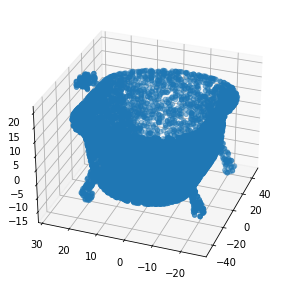

In [94]:
plot3D(train_images[0][1])

In [54]:
vertices = train_data[0][1][0]
faces = train_data[0][1][1]
pca = PCA(n_components=3)
vertices2d = pca.fit_transform(vertices)
pca.explained_variance_ratio_

array([0.49831891, 0.4373903 , 0.06429079])

In [44]:
#from occmodel import Face, Solid, OCCError

real_faces = []
for face in faces:

    points = []
    for i in range(1, len(face), 1):
        points.append(vertices2d[face[i]])

    real_faces.append(points)

# occfaces = []
# for real_face in real_faces:
#     if len(real_face) == 3:
#         try:
#             occfaces.append(Face().createPolygonal(real_face))
#         except OCCError as e:
#             print(e, real_face)
#     else:
#         assert(False)



In [48]:
real_faces_pcs = np.array(real_faces)
real_faces_pcs.shape

(29158, 3, 2)

In [71]:
train_final = np.array([i[1] for i in train_images])
train_labels = np.array([categories.index(l) for l in [i[0] for i in train_images]])

/tmp/ipykernel_126482/3398517217.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_final = np.array([i[1] for i in train_images])


In [72]:
test_final = np.array([i[1] for i in test_images])
test_labels = np.array([categories.index(l) for l in [i[0] for i in test_images]])

/tmp/ipykernel_126482/2808246889.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_final = np.array([i[1] for i in test_images])


In [78]:
train_final[2333].shape

(1184, 3, 2)

In [79]:
model = tf.keras.Sequential([
    # tf.keras.layers.Conv2D(60, kernel_size=(3, 3), input_shape=(240*4, 240*4, 1)),
    # tf.keras.layers.MaxPool2D(pool_size=(8, 8)),
    # tf.keras.layers.Conv2D(60, kernel_size=(3, 3)),
    # tf.keras.layers.MaxPool2D(pool_size=(8, 8)), # !!! 2 2
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

2022-01-14 18:55:31.742578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 18:55:31.742846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [82]:
model.fit(train_final, train_labels, epochs=40)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [65]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

29/29 - 0s - loss: 4.4401 - accuracy: 0.1112 - 81ms/epoch - 3ms/step

Test accuracy: 0.11123348027467728


In [ ]:
model.save("first.h5")
del model

In [ ]:
i = 0

In [ ]:
while 1:
    i += 1
    print(i)
    print(train_final.shape, train_labels.shape)
    model.fit(train_final, train_labels, epochs=1)
    test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
    print('Test accuracy:', test_acc, '\n')

In [ ]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
print('Test accuracy:', test_acc, '\n')

In [ ]:
model.save("third.h5")
np.save('train_final_third.npy', train_final)
np.save('test_final_third.npy', test_final)
np.save('train_labels_third.npy', train_labels)
np.save('test_labels_third.npy', test_labels)

In [ ]:
model = keras.models.load_model("third.h5")
train_final = np.load("train_final_third.npy")
test_final = np.load("test_final_third.npy")
train_labels = np.load("train_labels_third.npy")
test_labels = np.load("test_labels_third.npy")